In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from einops import einops as ein
from jaxtyping import Bool, Float, Int
from torch import Tensor as TT

from utils import seed_everything, ls
from sparse_autoencoders import toy_problem, SparseAutoEncoder, fit_sae

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


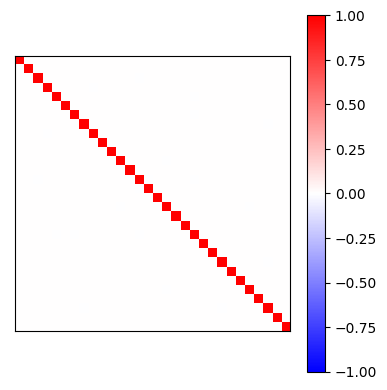

In [20]:
seed_everything(42)

n_samples = 10**4
d_sparse = 30
d_dense = 30

dense, sparse, directions = toy_problem(
    n_samples=n_samples,
    d_sparse=d_sparse,
    d_dense=d_dense,
    ortho=True,
    freq_decay=0.9,
    nonzero_rate=2.0,
)
assert_type(directions, Float[TT, "d_sparse d_dense"])


dir_cos: Float[TT, "d_sparse d_sparse"] = F.cosine_similarity(
    directions[:, None], directions[None, :], dim=-1
)
assert dir_cos[3, 5] == F.cosine_similarity(directions[3], directions[5], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(dir_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [42]:
from sparse_autoencoders import SparseAutoEncoder, fit_sae, max_cosine_similarity

# seed_everything(42)

d_dict = 40
sae = SparseAutoEncoder(d_dense, d_dict)
other = SparseAutoEncoder(d_dense, 2 * d_dict)

for it in range(10):
    fit_sae(sae, dense, lr=1e-2, l1=1e-2, alpha=1e-4, epochs=10, batch_size=2500)
    fit_sae(other, dense, lr=1e-2, l1=1e-2, alpha=1e-4, epochs=10, batch_size=2500)
    guess = sae.encode(dense).detach()
    other_guess = other.encode(dense).detach()
    assert_type(guess, Float[TT, "n_samples d_dict"])
    alive_count = (guess != 0).sum(dim=0)
    dead = (alive_count == 0).sum()
    print("dead =", dead.item())

    true_vs_guess = max_cosine_similarity(target=sparse, learned=guess)
    print(ls(true_vs_guess.mean()), ls(true_vs_guess))
    other_vs_guess = max_cosine_similarity(target=other_guess, learned=guess)
    print(ls(other_vs_guess.mean()), ls(other_vs_guess))
    guess_vs_other = max_cosine_similarity(target=guess, learned=other_guess)
    print(ls(guess_vs_other.mean()), ls(guess_vs_other))
    guess_vs_true = max_cosine_similarity(target=guess, learned=sparse)
    print(ls(guess_vs_true.mean()), ls(guess_vs_true))

  0%|          | 0/10 [00:00<?, ?it/s,  loss=29.03, nonzero=19.85 / 40, nonorth=1492.36]

100%|██████████| 10/10 [00:00<00:00, 17.77it/s,  loss=6.70, nonzero=19.68 / 80, nonorth=35.80] 


dead = 12
0.36 [ 0.76 0.43 0.61 0.50 0.30 0.33 0.19 0.35 0.29 0.53 0.20 0.33 0.71 0.45 0.46 0.31 0.20 0.15 0.47 0.20 0.33 0.24 0.22 0.08 0.40 0.46 0.23 0.20 0.37 0.54 ]
0.20 [ 0.03 0.45 0.10 0.30 0.00 0.19 0.22 0.11 0.00 0.00 0.20 0.00 0.00 0.15 0.00 0.01 0.00 0.47 0.10 0.00 0.91 0.19 0.00 0.46 0.00 0.00 0.00 0.00 0.53 0.34 0.14 0.39 0.00 0.20 0.36 0.00 0.17 0.00 0.47 0.20 0.75 0.23 0.00 0.00 0.37 0.32 0.03 0.00 0.07 0.38 0.43 0.00 0.19 0.32 0.14 0.13 0.35 0.23 0.01 0.00 0.31 0.27 0.14 0.39 0.43 0.27 0.00 0.11 0.34 0.34 0.25 0.16 0.01 0.07 0.32 0.94 0.18 0.48 0.36 0.00 ]
0.24 [ 0.28 0.53 0.00 0.39 0.38 0.00 0.36 0.27 0.23 0.38 0.46 0.33 0.16 0.00 0.00 0.00 0.00 0.32 0.32 0.19 0.25 0.00 0.19 0.75 0.24 0.40 0.00 0.00 0.36 0.00 0.00 0.14 0.16 0.00 0.30 0.45 0.34 0.94 0.45 0.10 ]
0.25 [ 0.45 0.46 0.00 0.61 0.53 0.00 0.29 0.54 0.17 0.71 0.25 0.46 0.54 0.00 0.00 0.00 0.00 0.07 0.10 0.33 0.30 0.00 0.15 0.76 0.17 0.29 0.00 0.00 0.47 0.00 0.00 0.12 0.23 0.00 0.11 0.43 0.43 0.29 0.40 0.15 ]


100%|██████████| 10/10 [00:00<00:00, 19.65it/s,  loss=0.15, nonzero=17.37 / 80, nonorth=136.99]


dead = 2
0.67 [ 0.94 0.95 0.91 0.81 0.98 0.91 0.82 0.87 0.80 0.83 0.81 0.90 0.90 0.88 0.48 0.79 0.38 0.93 0.47 0.35 0.74 0.63 0.50 0.63 0.36 0.71 0.18 0.10 0.15 0.49 ]
0.51 [ 0.59 0.31 0.81 0.72 0.68 0.76 0.92 0.69 0.00 0.24 0.54 0.89 0.10 0.50 0.30 0.84 0.00 0.61 0.55 0.60 0.13 0.69 0.00 0.00 0.15 0.00 0.69 0.39 0.60 0.46 0.57 0.57 0.00 0.66 0.79 0.84 0.66 0.60 0.22 0.85 0.91 0.73 0.00 0.04 0.74 0.59 0.86 0.05 0.53 0.71 0.61 0.90 0.53 0.32 0.65 0.69 0.20 0.55 0.94 0.25 0.59 0.80 0.74 0.48 0.59 0.84 0.43 0.75 0.81 0.74 0.51 0.58 0.38 0.60 0.46 0.35 0.00 0.49 0.64 0.00 ]
0.65 [ 0.68 0.60 0.60 0.61 0.71 0.81 0.91 0.84 0.90 0.68 0.69 0.66 0.69 0.46 0.44 0.81 0.86 0.74 0.78 0.65 0.59 0.00 0.84 0.79 0.57 0.64 0.39 0.75 0.79 0.22 0.40 0.89 0.22 0.00 0.81 0.59 0.92 0.69 0.84 0.94 ]
0.67 [ 0.73 0.59 0.63 0.71 0.83 0.81 0.94 0.85 0.93 0.90 0.80 0.53 0.79 0.50 0.30 0.82 0.91 0.81 0.81 0.74 0.56 0.00 0.77 0.79 0.53 0.68 0.30 0.63 0.87 0.20 0.35 0.98 0.47 0.00 0.91 0.61 0.95 0.63 0.88 0.90 ]


100%|██████████| 10/10 [00:00<00:00, 14.46it/s,  loss=0.01, nonzero=18.27 / 80, nonorth=97.87]


dead = 2
0.82 [ 1.00 1.00 0.98 0.96 1.00 0.96 0.91 0.96 0.95 1.00 0.99 0.99 0.97 0.96 0.56 0.95 0.65 1.00 0.78 0.80 0.74 0.95 0.70 0.74 0.47 0.54 0.58 0.47 0.56 0.54 ]
0.65 [ 0.86 0.45 0.89 0.53 0.95 0.98 0.98 0.99 0.00 0.51 0.49 0.99 0.91 0.58 0.33 0.95 0.00 0.67 0.23 0.72 0.00 0.96 0.00 0.00 0.00 0.00 0.90 0.80 0.81 0.69 0.75 0.90 0.00 0.82 0.98 0.96 0.84 0.59 0.63 0.98 1.00 0.55 0.00 0.00 0.86 0.77 0.94 0.42 0.62 0.95 0.67 0.97 0.80 0.82 0.74 0.94 0.33 0.77 1.00 0.33 0.57 0.92 1.00 0.29 0.96 0.98 0.61 0.54 0.94 0.98 0.77 0.67 0.65 0.87 0.71 0.81 0.00 0.79 0.69 0.00 ]
0.78 [ 0.91 0.81 0.72 0.68 0.96 0.79 1.00 0.98 0.97 0.95 0.94 0.58 0.67 0.55 0.81 0.89 0.94 1.00 0.90 0.74 0.63 0.00 0.95 0.84 0.67 0.91 0.92 0.82 0.69 0.10 0.98 0.99 0.77 0.00 0.90 0.54 0.98 0.96 0.96 1.00 ]
0.78 [ 0.90 0.55 0.74 0.58 1.00 0.80 1.00 0.98 1.00 0.97 0.95 0.50 0.67 0.70 0.81 0.91 0.96 0.99 0.90 0.74 0.56 0.00 0.96 0.85 0.68 0.95 0.94 0.80 0.67 0.09 0.96 1.00 0.78 0.00 0.90 0.55 1.00 0.95 0.96 0.99 ]


100%|██████████| 10/10 [00:00<00:00, 18.60it/s,  loss=0.00, nonzero=12.35 / 80, nonorth=63.50]


dead = 3
0.91 [ 1.00 0.99 0.99 0.99 0.99 0.97 0.98 0.99 1.00 0.99 0.99 0.99 0.98 0.99 0.91 0.99 0.83 1.00 0.88 0.86 0.80 0.98 0.91 0.96 0.85 0.65 0.93 0.49 0.72 0.79 ]
0.65 [ 0.63 0.86 0.98 0.00 0.99 1.00 0.99 1.00 0.00 0.85 0.86 0.99 0.98 0.90 0.00 0.99 0.00 0.72 0.00 0.95 0.00 0.98 0.00 0.00 0.00 0.00 0.95 0.84 0.68 0.00 0.85 0.92 0.00 0.83 0.97 0.99 0.00 0.91 0.74 0.99 1.00 0.91 0.54 0.00 0.50 0.89 0.96 0.49 0.92 0.98 0.72 1.00 0.85 0.86 0.80 0.99 0.00 0.00 1.00 0.41 0.39 0.97 1.00 0.26 0.99 1.00 0.62 0.65 0.97 0.99 0.93 0.82 0.84 0.96 0.92 0.67 0.00 0.52 0.68 0.00 ]
0.85 [ 0.79 0.90 0.95 0.85 0.99 0.75 1.00 1.00 1.00 0.99 0.99 0.86 0.63 0.91 0.94 0.98 0.97 1.00 0.94 0.84 0.74 0.00 0.99 0.92 0.80 0.98 0.96 0.86 0.92 0.00 1.00 0.99 0.93 0.00 0.83 0.65 0.99 0.98 0.99 1.00 ]
0.85 [ 0.79 0.91 0.96 0.93 0.99 0.82 1.00 0.99 1.00 0.98 1.00 0.85 0.79 0.91 0.93 0.98 0.97 0.99 0.94 0.83 0.72 0.00 0.99 0.93 0.80 0.99 0.95 0.86 0.88 0.00 0.99 0.99 0.84 0.00 0.82 0.65 0.99 0.98 0.99 0.99 ]


100%|██████████| 10/10 [00:00<00:00, 18.42it/s,  loss=0.00, nonzero=6.61 / 80, nonorth=43.33]


dead = 3
0.96 [ 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.98 0.99 1.00 0.99 0.98 0.99 0.88 0.97 0.87 0.99 0.89 1.00 0.95 0.94 0.96 0.53 0.98 0.99 ]
0.63 [ 1.00 0.96 1.00 0.00 0.99 1.00 1.00 1.00 0.00 0.92 0.86 1.00 1.00 1.00 0.00 0.99 0.00 0.00 0.00 1.00 0.00 0.99 0.00 0.00 0.00 0.00 0.97 0.25 0.89 0.00 0.78 0.81 0.00 0.74 0.73 1.00 0.00 0.89 0.97 0.96 1.00 0.87 0.56 0.00 0.00 0.25 0.97 0.53 0.87 0.99 0.79 1.00 0.80 0.97 0.87 0.99 0.00 0.00 1.00 0.00 0.00 0.97 1.00 0.00 1.00 1.00 0.00 0.95 0.99 0.94 0.98 0.97 0.99 0.97 0.98 0.98 0.00 0.29 0.85 0.45 ]
0.86 [ 0.97 1.00 1.00 0.97 1.00 0.97 1.00 1.00 1.00 0.99 0.99 0.96 1.00 0.89 0.38 1.00 0.99 1.00 0.95 0.77 0.98 0.00 0.99 0.26 0.87 1.00 0.90 0.90 0.84 0.00 1.00 1.00 0.98 0.00 0.99 0.95 1.00 0.99 1.00 1.00 ]
0.85 [ 0.97 1.00 1.00 0.96 0.99 0.96 0.99 0.99 0.99 0.98 0.99 0.95 0.99 0.89 0.36 0.99 0.99 0.99 0.93 0.76 0.98 0.00 0.99 0.24 0.87 0.99 0.89 0.89 0.83 0.00 0.99 0.99 0.88 0.00 0.98 0.94 0.99 0.99 0.99 0.99 ]


100%|██████████| 10/10 [00:00<00:00, 14.00it/s,  loss=0.00, nonzero=4.19 / 80, nonorth=33.97]


dead = 5
0.97 [ 0.99 0.99 1.00 0.99 0.99 0.99 1.00 0.99 0.99 0.99 0.99 0.99 0.99 0.99 1.00 0.99 0.99 0.99 0.84 0.98 0.95 1.00 0.86 0.99 0.99 0.97 0.98 0.60 0.99 0.99 ]
0.51 [ 1.00 0.99 1.00 0.00 1.00 1.00 1.00 0.89 0.00 0.97 0.00 1.00 1.00 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 0.99 0.00 0.77 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.87 1.00 0.00 1.00 0.86 0.00 0.00 0.00 0.00 0.00 0.62 0.83 1.00 0.99 1.00 0.74 0.99 0.97 1.00 0.00 0.00 1.00 0.00 0.00 0.88 1.00 0.00 1.00 1.00 0.00 0.97 1.00 0.00 0.95 0.99 1.00 0.00 0.99 1.00 0.00 0.04 0.85 0.00 ]
0.83 [ 0.99 1.00 1.00 0.99 1.00 0.97 1.00 1.00 1.00 1.00 1.00 0.99 1.00 0.87 0.00 1.00 1.00 1.00 0.57 0.76 1.00 0.00 1.00 0.62 0.97 1.00 0.00 0.87 0.85 0.00 1.00 1.00 0.95 0.00 1.00 0.97 1.00 1.00 1.00 1.00 ]
0.82 [ 0.98 1.00 0.99 0.98 0.99 0.93 0.99 1.00 0.99 0.99 0.99 0.99 0.99 0.86 0.00 1.00 0.99 0.99 0.57 0.74 0.99 0.00 0.99 0.60 0.95 0.99 0.00 0.87 0.84 0.00 0.99 0.99 0.83 0.00 0.99 0.97 0.99 1.00 0.99 0.99 ]


100%|██████████| 10/10 [00:00<00:00, 19.80it/s,  loss=0.00, nonzero=2.98 / 80, nonorth=31.91]


dead = 7
0.98 [ 1.00 0.99 1.00 1.00 1.00 1.00 0.99 0.99 1.00 0.99 1.00 1.00 0.99 0.99 0.99 0.99 0.99 0.99 0.88 0.97 0.96 0.99 0.95 0.99 0.99 0.99 0.99 0.92 0.99 0.99 ]
0.48 [ 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.00 0.99 0.00 1.00 1.00 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.97 1.00 0.00 1.00 0.96 0.00 0.00 0.00 0.00 0.00 0.93 0.87 1.00 0.99 1.00 0.14 0.98 0.97 1.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 1.00 1.00 0.00 0.99 1.00 0.00 0.95 1.00 1.00 0.00 0.98 1.00 0.00 0.03 0.89 0.00 ]
0.81 [ 0.98 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.97 0.00 1.00 1.00 1.00 0.00 0.89 1.00 0.00 1.00 0.93 0.97 1.00 0.00 0.90 0.89 0.00 1.00 1.00 0.95 0.00 1.00 0.99 1.00 1.00 1.00 1.00 ]
0.80 [ 0.97 0.99 0.99 0.99 0.99 0.00 1.00 1.00 0.99 0.99 1.00 0.99 0.99 0.95 0.00 0.99 1.00 1.00 0.00 0.88 0.99 0.00 1.00 0.92 0.96 0.99 0.00 0.89 0.88 0.00 0.99 1.00 0.86 0.00 0.99 0.99 0.99 0.99 0.99 1.00 ]


100%|██████████| 10/10 [00:00<00:00, 18.55it/s,  loss=0.00, nonzero=2.67 / 80, nonorth=30.80]


dead = 7
0.99 [ 0.99 1.00 1.00 1.00 1.00 0.99 1.00 1.00 1.00 0.99 0.99 1.00 0.99 1.00 1.00 1.00 1.00 1.00 0.96 0.97 0.98 1.00 0.99 1.00 0.99 0.99 0.99 0.98 1.00 0.99 ]
0.48 [ 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.00 1.00 0.00 1.00 0.99 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00 1.00 0.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.99 0.96 1.00 0.98 1.00 0.00 0.98 0.99 1.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.98 1.00 0.00 0.99 1.00 0.00 0.97 0.98 1.00 0.00 0.91 0.99 0.00 0.00 0.99 0.00 ]
0.82 [ 0.98 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.96 1.00 0.00 1.00 0.99 0.99 1.00 0.00 0.93 0.99 0.00 1.00 1.00 0.97 0.00 1.00 0.99 1.00 1.00 1.00 1.00 ]
0.81 [ 0.97 1.00 1.00 0.99 0.99 0.00 0.99 1.00 1.00 0.99 1.00 0.99 0.99 0.99 0.00 1.00 0.99 0.99 0.00 0.95 1.00 0.00 1.00 0.98 0.98 1.00 0.00 0.92 0.96 0.00 1.00 1.00 0.93 0.00 1.00 0.99 1.00 1.00 1.00 1.00 ]


100%|██████████| 10/10 [00:00<00:00, 18.51it/s,  loss=0.00, nonzero=2.47 / 80, nonorth=28.96]


dead = 7
0.99 [ 1.00 1.00 1.00 1.00 0.99 0.99 1.00 0.99 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.99 0.97 0.96 0.98 1.00 0.99 1.00 0.99 0.99 1.00 0.99 0.99 0.99 ]
0.46 [ 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.00 1.00 0.00 1.00 0.90 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.99 1.00 0.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.95 1.00 0.49 1.00 0.00 0.96 0.99 1.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.84 1.00 0.00 0.99 1.00 0.00 0.98 0.85 1.00 0.00 0.00 0.99 0.00 0.00 0.97 0.00 ]
0.82 [ 0.96 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.96 1.00 0.00 1.00 1.00 0.99 1.00 0.00 0.96 0.97 0.00 1.00 1.00 0.98 0.00 1.00 0.99 1.00 1.00 1.00 1.00 ]
0.82 [ 0.96 1.00 1.00 1.00 1.00 0.00 1.00 1.00 0.99 1.00 1.00 0.99 0.99 0.99 0.00 1.00 0.99 1.00 0.00 0.95 0.99 0.00 1.00 0.99 0.98 1.00 0.00 0.96 0.96 0.00 0.99 0.99 0.97 0.00 1.00 0.99 1.00 1.00 1.00 1.00 ]


100%|██████████| 10/10 [00:00<00:00, 20.00it/s,  loss=0.00, nonzero=2.41 / 80, nonorth=27.89]


dead = 7
0.99 [ 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.99 1.00 1.00 1.00 0.99 1.00 1.00 1.00 0.99 1.00 0.98 0.99 0.97 1.00 1.00 0.99 0.99 0.99 1.00 0.99 0.99 0.99 ]
0.40 [ 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.00 1.00 0.00 1.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.95 1.00 0.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 1.00 0.00 1.00 0.98 1.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00 0.00 1.00 1.00 0.00 0.99 0.00 1.00 0.00 0.00 0.97 0.00 0.00 0.00 0.00 ]
0.82 [ 0.90 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 0.00 0.98 1.00 0.00 1.00 1.00 0.98 1.00 0.00 1.00 0.94 0.00 1.00 1.00 0.99 0.00 1.00 1.00 1.00 1.00 1.00 1.00 ]
0.81 [ 0.88 1.00 0.99 1.00 1.00 0.00 1.00 1.00 1.00 0.99 0.99 0.99 0.99 1.00 0.00 1.00 1.00 1.00 0.00 0.97 0.99 0.00 1.00 0.99 0.97 1.00 0.00 0.99 0.93 0.00 1.00 1.00 0.98 0.00 0.99 0.99 1.00 1.00 1.00 1.00 ]


[50, 20]


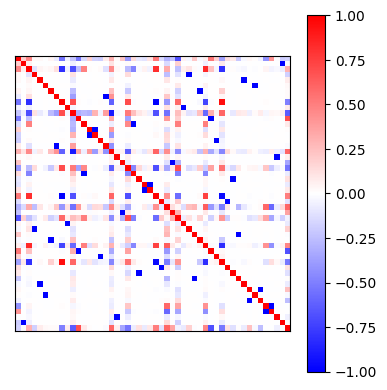

[50, 10000]


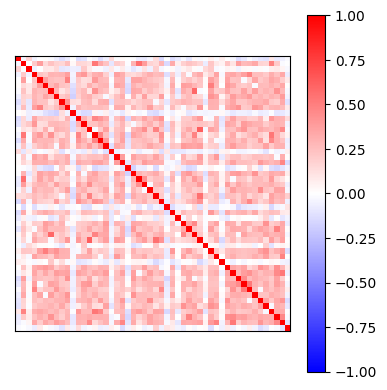

In [77]:
from utils import sh

W = sae.weight.detach().T
print(sh(W))
W_cos = F.cosine_similarity(W[:, None], W[None, :], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(W_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

W = guess.T.detach()
print(sh(W))
W_cos = F.cosine_similarity(W[:, None], W[None, :], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(W_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()